# About

Testing SVR Regression on Retrieval Task.

In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import torch, torch.nn.functional as F
import os
import gc 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cudf
import cuml
import numba.cuda

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from heapq import nlargest
from io import StringIO
from tqdm.auto import tqdm
from transformers import AutoModel,AutoTokenizer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from cuml.svm import SVR as cumlSVR
from cuml.preprocessing import StandardScaler as cumlStandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/tmp/ipykernel_3686731/1415649699.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/home/staff_homes/kboenisc/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_colwidth', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(device)
print(available_gpus)

cuda
[<torch.cuda.device object at 0x7f17676de920>, <torch.cuda.device object at 0x7f17676dfc70>]


In [3]:
class Config:
    GERDALIR_PATH = './data/GerDaLIR/'
    EMBEDDINGS_DIRECTORY = './data/embeddings/'
    COMBINED_EMBEDDINGS = './data/embeddings/combined_{TYPE}_.npy'
    REMOVE_STOPWORDS = False
    EPXLODE_SENTENCES = True
    USE_TFIDF = False
    CHUNK_QUERIES = False

# Read Data

In [4]:
def read_tsv(file_path):
    data = []
    with open(file_path, 'r', encoding='utf8') as file:
        for line in file:
            columns = line.strip().split('\t')
            # Concatenate columns from index 1 onwards (since we have some broken rows)
            concatenated_value = ''.join(columns[1:])
            data.append((columns[0], concatenated_value))

    df = pd.DataFrame(data, columns=['id', 'value'])
    return df

In [5]:
collection = read_tsv(Config.GERDALIR_PATH + 'collection/collection.tsv').head(99900000)
collection.rename(columns={'id': 'd_id', 'value':'passage'}, inplace=True)
collection.reset_index(inplace=True)

rels = read_tsv(Config.GERDALIR_PATH + 'qrels/qrels.train.tsv')
rels.rename(columns={'id': 'q_id', 'value': 'd_id'}, inplace=True)
rels = rels[rels['d_id'].isin(collection['d_id'].values)] # This can be deleted once we work with all
rels.reset_index(inplace=True)

queries = read_tsv(Config.GERDALIR_PATH + 'queries/queries.train.tsv')
queries.rename(columns={'id': 'q_id', 'value': 'query'}, inplace=True)
queries = queries[queries['q_id'].isin(rels['q_id'].values)] # This can be deleted once we work with all
queries.reset_index(inplace=True)

In [6]:
display(queries.head(2))
display(len(queries))

display(collection.head(2))
display(len(collection))

display(rels.head(2))
display(len(rels))

,index,q_id,query
0,0,2,"Nach [REF] ist eine Erlaubnis zu widerrufen, wenn nachträglich bekannt wird, dass die Voraussetzung nach § 0 Nummer 0 nicht erfüllt ist. Gemäß [REF] setzt die Erlaubnis zum Führen der Berufsbezeichnung voraus, dass die antragstellende Person sich nicht eines Verhaltens schuldig gemacht hat, aus dem sich die Unzuverlässigkeit zur Ausübung des Berufes ergibt. Der gerichtlich voll überprüfbare unbestimmte Rechtsbegriff der Zuverlässigkeit bezeichnet ein Instrument sicherheits und ordnungsrechtlicher Gefahrenabwehr. Der Ausschluss unzuverlässiger Erlaubnisbewerber bzw. inhaber hat demgemäß präventiven Charakter und dient der Abwehr von Gefahren für das Gemeinwohl. Unzuverlässigkeit i. S. d. der Bestimmungen ist dabei in Anlehnung an entsprechende Begrifflichkeiten in anderen, auch heilberufsrechtlichen Bestimmungen anzunehmen, wenn bei prognostischer Betrachtung auf Grund einer Würdigung der gesamten Persönlichkeit, des Gesamtverhaltens und der Lebensumstände des Betreffenden unter Berücksichtigung der Eigenart des Berufs nicht die Gewähr besteht, dass dieser in Zukunft seine beruflichen Pflichten zuverlässig erfüllen wird. Für die gebotene Prognose ist dabei abzustellen auf die jeweilige Situation des Betreffenden im maßgeblichen Zeitpunkt, der regelmäßig im Abschluss des behördlichen Verfahrens liegt, sowie auf vor allem durch die Art, Schwere und Zahl der Verstöße gegen die Berufspflichten manifest gewordenen Charakter des Betreffenden."
1,1,3,"Erforderlich ist mithin eine Prognoseentscheidung unter Berücksichtigung aller Umstände des Einzelfalls dahingehend, ob der Betreffende willens und in der Lage sein wird, künftig seine beruflichen Pflichten zuverlässig zu erfüllen."


98380

,index,d_id,passage
0,0,1,Tenor Der Antrag der Klägerin auf Zulassung der Berufung gegen das Urteil des Verwaltungsgerichts Gelsenkirchen vom [DATE] wird abgelehnt. Die Klägerin trägt die Kosten des Zulassungsverfahrens. Der Streitwert wird auch für das Zulassungsverfahren auf 0 Euro festgesetzt. Gründe:
1,1,1,"Das Zulassungsvorbringen der Klägerin begründet keine ernstlichen Zweifel an der Richtigkeit des angefochtenen Urteils . Zweifel in diesem Sinn sind anzunehmen, wenn ein einzelner tragender Rechtssatz oder eine einzelne erhebliche Tatsachenfeststellung des Verwaltungsgerichts mit schlüssigen Gegenargumenten in Frage gestellt werden."


3095383

,index,q_id,d_id
0,0,2,118149
1,1,3,72511


115360

# Postprocess

In [7]:
def chunk_string_with_overlap(s, k, overlap):
    if k <= 0:
        raise ValueError("Chunk length must be greater than 0")
    if overlap < 0:
        raise ValueError("Overlap must be non-negative")
    if overlap >= k:
        raise ValueError("Overlap must be less than chunk length")
    
    chunks = []
    for i in range(0, len(s), k - overlap):
        chunk = s[i:i + k]
        chunks.append(chunk)
        if len(chunk) < k:
            break
    
    return chunks

Average length of queries:

In [8]:
print(queries['query'].apply(lambda x: len(x.split())).mean())
print(queries['query'].apply(lambda x: len(x)).mean())

137.06715795893473
1043.171305143322


In [9]:
if(Config.CHUNK_QUERIES):
    queries['query'] = queries['query'].apply(lambda q: chunk_string_with_overlap(q, 275, 15))
    queries = queries.explode('query').reset_index(drop=True)
    display(queries.head(10))
    print(len(queries))

# Embeddings

In [10]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [11]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length, text_col):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.max = max_length

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.loc[idx, self.text_col]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [12]:
class EmbedderContainer:

    def __init__(self, model_name, max_length, batch_size, device):
        self.device = device
        self.model_name = model_name
        self.__model_path = model_name
        self.__max_length = max_length
        self.__batch_size = batch_size

    def init_model(self):
        self.__model = AutoModel.from_pretrained(self.__model_path, trust_remote_code=True).to(self.device)  #force_download=True
        self.__model.eval()
        self.__tokenizer = AutoTokenizer.from_pretrained(self.__model_path, trust_remote_code=True)  #force_download=True

    def init_embed_dataset(self, df, text_col):
        self.__dataset = EmbedDataset(df, self.__tokenizer, self.__max_length, text_col)
        self.__embed_dataloader = torch.utils.data.DataLoader(self.__dataset,
                                batch_size=self.__batch_size,
                                shuffle=False)
        return self.__embed_dataloader

    def embed(self, input_ids, attention_mask):
        return self.__model(input_ids=input_ids, attention_mask=attention_mask)

    def dispose(self):
        if hasattr(self, '__dataset'):
            del self.__dataset
        if hasattr(self, '__embed_dataloader'):
            del self.__embed_dataloader
        if hasattr(self, '__model'):
            del self.__model
        if hasattr(self, '__tokenizer'):
            del self.__tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    

In [13]:
def get_embeddings(embedding_container, compute_collection=True, compute_queries=False):

    global collection, queries
    embedding_container.init_model()

    # COMPUTE COLLECTION EMBEDDINGS
    all_collection_embeddings = []
    if compute_collection:
        # Create dataset for collection
        embed_dataloader_tr = embedding_container.init_embed_dataset(collection, 'passage')
        for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)

            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_collection_embeddings.extend(sentence_embeddings)
    all_collection_embeddings = np.array(all_collection_embeddings)

    # COMPUTE QUERY EMBEDDINGS
    all_query_embeddings = []
    if compute_queries:
        # Create dataset for query
        embed_dataloader_te = embedding_container.init_embed_dataset(queries, 'query')
        for batch in embed_dataloader_te:
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_query_embeddings.extend(sentence_embeddings)
    all_query_embeddings = np.array(all_query_embeddings)

    # DISPOSE
    if 'model_output' in locals():
        del model_output
    if 'sentence_embeddings' in locals():
        del sentence_embeddings
    if 'input_ids' in locals():
        del input_ids
    if 'attention_mask' in locals():
        del attention_mask
    embedding_container.dispose()

    # RETURN EMBEDDINGS
    return all_collection_embeddings, all_query_embeddings

### Possible Embedding Models

In [14]:
DEVICE = "cuda:1" # We want to extract embeddings on the second GPU.

container = [
    #EmbedderContainer('microsoft/deberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('microsoft/deberta-large', 1024, 8, DEVICE),
    #EmbedderContainer('microsoft/deberta-v3-large', 1024, 8, DEVICE),
    EmbedderContainer('allenai/longformer-base-4096', 1024, 32, DEVICE),
    #EmbedderContainer('LennartKeller/longformer-gottbert-base-8192-aw512', 1024, 32, DEVICE),
    #EmbedderContainer('allenai/longformer-large-4096', 1024, 8, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-large', 1024, 8, DEVICE),

    # Sentence Transformers fine-tuned for sentence embeddings:
    # EmbedderContainer('sentence-transformers/all-distilroberta-v1', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/all-distilroberta-v1
    # EmbedderContainer('sentence-transformers/msmarco-distilbert-base-v4', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v4
    #EmbedderContainer('sentence-transformers/all-MiniLM-L6-v2', 384, 64, DEVICE), # https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
]

### Generate Embeddings

In [15]:
all_collection_embeds = []
all_query_embeds = []

calculate = True

In [16]:
if(os.path.exists(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'collection_full'))):
    all_collection_embeds = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'collection_full'))
    all_query_embeds = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'query_train'))
    calculate = False

In [17]:
if(calculate):
    for embedding_container in container:
        name = (Config.EMBEDDINGS_DIRECTORY + 
                'collection_' + 
                embedding_container.model_name.replace("/", "_") + 
                ".npy")
        
        if os.path.exists(name):
            print(f"Loading embeddings for {name}")
            _, query_embed = get_embeddings(embedding_container, compute_collection=False, compute_queries=True)
            collection_embed = np.load(name)
        else:
            print(f"Computing embeddings for {name}") 
            collection_embed, query_embed = get_embeddings(embedding_container, compute_collection=True, compute_queries=True)
            np.save(name, collection_embed)
        all_collection_embeds.append(collection_embed)
        all_query_embeds.append(query_embed)

    del collection_embed, query_embed

Loading embeddings for ./data/embeddings/collection_allenai_longformer-base-4096.npy


/home/staff_homes/kboenisc/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
if(calculate):
    all_collection_embeds = np.concatenate(all_collection_embeds,axis=1)
    all_query_embeds = np.concatenate(all_query_embeds,axis=1)

In [19]:
print(all_collection_embeds.shape)
print(all_query_embeds.shape)

(3095383, 768)
(98380, 768)


In [20]:
gc.collect()

11

In [21]:
if(calculate):
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'collection_full'), all_collection_embeds)
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'query_train'), all_query_embeds)

# Training

In [22]:
features = []
labels = []
calculate_feat = True

if(os.path.exists(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'features'))):
    features = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'features'))
    labels = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'labels'))
    calculate_feat = False

subsampling_top_k = 100

# query_idx_lookup = {qid: idx for idx, qid in enumerate(queries['q_id'])}
passage_idx_lookup = {pid: idx for idx, pid in enumerate(collection['d_id'])}

In [23]:
def query_fits_passage(q_idx, c_idx):
    '''Does the given collection index fit to a given query index?'''
    q_id = queries.iloc[q_idx]['q_id']
    d_id = collection.iloc[c_idx]['d_id']
    return len(rels[(rels['q_id'] == q_id) & (rels['d_id'] == d_id)].values) > 0

**Convert to cupy arrays for faster GPU cosine sims**

In [24]:
if(calculate_feat):
    all_query_embeds_cp = cp.asarray(all_query_embeds, dtype=cp.float16) 
    all_collection_embeds_cp = cp.asarray(all_collection_embeds, dtype=cp.float16)

In [25]:
# Loop through queries
if(calculate_feat):
    for q_idx, row in tqdm(queries.iterrows(), total=len(queries), desc='Processing Queries'):
        query_id = row['q_id']
        query_embed_cp = all_query_embeds_cp[q_idx]

        # Positive samples
        positive_indices = set()
        rels_for_query = rels[rels['q_id'] == query_id]
        for passage_id in rels_for_query['d_id']:
            if passage_id in passage_idx_lookup:
                passage_idx = passage_idx_lookup[passage_id]
                #print('Correct answer:')
                #print(collection.iloc[passage_idx]['passage'])
                passage_embed_cp = all_collection_embeds_cp[passage_idx]

                # Convert CuPy arrays back to NumPy
                query_embed_np = cp.asnumpy(query_embed_cp)
                passage_embed_np = cp.asnumpy(passage_embed_cp)

                # Concatenate using NumPy
                feature_np = np.concatenate((query_embed_np, passage_embed_np))
                features.append(feature_np)  # Append NumPy array
                labels.append(1)
                positive_indices.add(passage_idx)
        
        # Compute cosine similarity on GPU
        cos_sim_cp = 1 - cp.matmul(query_embed_cp, all_collection_embeds_cp.T)
        top_k_indices = cp.asnumpy(cp.argpartition(cos_sim_cp, subsampling_top_k + len(positive_indices))[:subsampling_top_k + len(positive_indices)])
        negative_indices = top_k_indices[:subsampling_top_k]
        #print('Query')
        #print(queries.iloc[q_idx]['query'])
        #print('Passage')
        #print(collection.iloc[negative_indices[0]]['passage'])
        #print('\n\n')

        for passage_idx in negative_indices:
            passage_embed_cp = all_collection_embeds_cp[passage_idx]

            # Convert CuPy arrays back to NumPy
            query_embed_np = cp.asnumpy(query_embed_cp)
            passage_embed_np = cp.asnumpy(passage_embed_cp)

            # Concatenate using NumPy
            feature_np = np.concatenate((query_embed_np, passage_embed_np)).astype(np.float16)
            features.append(feature_np)  # Append NumPy array
            labels.append(0)

        # Explicitly free memory if needed
        # cp.get_default_memory_pool().free_all_blocks()


Processing Queries: 100%|█████████████████████████████████████████████████████████| 98380/98380 [45:52<00:00, 35.75it/s]


In [26]:
if(calculate_feat):
    features = np.array(features)
    labels = np.array(labels) 

In [27]:
print(features.dtype)

float16


In [28]:
if(calculate_feat):
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'features'), features)
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'labels'), labels)

OSError: [Errno 5] Input/output error

In [ ]:
# Ensure there are no NaNs or infinities in the data
#if np.any(np.isnan(features)) or np.any(np.isinf(features)):
#    raise ValueError("Input data contains NaNs or infinite values")

In [29]:
print(features.shape)
print(labels.shape)
print(labels[:200])
print('Negative labels: ' + str(len(list(filter(lambda x: x == 0, labels)))))
print('Positive labels: ' + str(len(list(filter(lambda x: x > 0, labels)))))


(9953360, 1536)
(9953360,)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Negative labels: 9838000
Positive labels: 115360


In [30]:
if 'all_collection_embeds' in locals() and 'all_collection_embeds_cp' in locals():
    del all_collection_embeds, all_collection_embeds_cp, all_query_embeds, all_query_embeds_cp
    gc.collect()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [32]:
print(len(X_train))
print(len(X_train))
print(len(y_train))
print(len(y_test))

8958024
8958024
8958024
995336


In [33]:
del features, labels

gc.collect()

0

**Even with subsampling, we still have a class imbalance. Counter that:**

*Update*: Yikes, RAPIDS doesn't support passing the class_weights into the SVR yet.

In [34]:
# Compute class weights to handle imbalance
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Bagging

We have too many features and datapoints, which a single SVR can't handle on this machine. Instead, I'm going to:

- Train X different SVR using a portion of the rows
- Ensemble the SVRs
- In that way duplicate the bagging of Random Forest

In [35]:
# Helper function to create random subsets with overlap
def create_subsets(X, y, num_subsets, overlap_percentage):
    subsets = []
    subset_size = int((len(X) // num_subsets) * overlap_percentage)
    num_samples = len(X)
    
    for _ in range(num_subsets):
        subset_indices = np.random.choice(num_samples, size=subset_size, replace=True)
        X_subset = X[subset_indices]
        y_subset = y[subset_indices]
        subsets.append((X_subset, y_subset))
        print(f'Done with {_}/{num_subsets}')
    
    return subsets

In [36]:
# Logging function to track progress
def log_progress(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    f1 = f1_score(y_val, y_pred_binary)
    accuracy = accuracy_score(y_val, y_pred_binary)
    
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')

### Normalize

There is no way we fit 200GB of features into the GPU at once to transform the data. Hence, we calculate the fitting on the CPU with the standard scaler, chunk it and then transform in chunks.

In [37]:
def chunkify(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

# Initialize a CPU-based StandardScaler
cpu_scaler = StandardScaler()

# Fit the CPU scaler incrementally on each chunk of X_train
chunk_size = 25000
count = 0
total = len(X_train) // chunk_size
for chunk in chunkify(X_train, chunk_size):
    print(f'Doing Chunk: {count}/{total}')
    cpu_scaler.partial_fit(chunk)
    count += 1

Doing Chunk: 0/358
Doing Chunk: 1/358
Doing Chunk: 2/358
Doing Chunk: 3/358
Doing Chunk: 4/358
Doing Chunk: 5/358
Doing Chunk: 6/358
Doing Chunk: 7/358
Doing Chunk: 8/358
Doing Chunk: 9/358
Doing Chunk: 10/358
Doing Chunk: 11/358
Doing Chunk: 12/358
Doing Chunk: 13/358
Doing Chunk: 14/358
Doing Chunk: 15/358
Doing Chunk: 16/358
Doing Chunk: 17/358
Doing Chunk: 18/358
Doing Chunk: 19/358
Doing Chunk: 20/358
Doing Chunk: 21/358
Doing Chunk: 22/358
Doing Chunk: 23/358
Doing Chunk: 24/358
Doing Chunk: 25/358
Doing Chunk: 26/358
Doing Chunk: 27/358
Doing Chunk: 28/358
Doing Chunk: 29/358
Doing Chunk: 30/358
Doing Chunk: 31/358
Doing Chunk: 32/358
Doing Chunk: 33/358
Doing Chunk: 34/358
Doing Chunk: 35/358
Doing Chunk: 36/358
Doing Chunk: 37/358
Doing Chunk: 38/358
Doing Chunk: 39/358
Doing Chunk: 40/358
Doing Chunk: 41/358
Doing Chunk: 42/358
Doing Chunk: 43/358
Doing Chunk: 44/358
Doing Chunk: 45/358
Doing Chunk: 46/358
Doing Chunk: 47/358
Doing Chunk: 48/358
Doing Chunk: 49/358
Doing Chun

**Save the scaler for the test inference**

In [38]:
with open('cpu_scaler.pkl', 'wb') as file:
    pickle.dump(cpu_scaler, file)

In [39]:
def transform_in_chunks(scaler, data, chunk_size):
    count = 0
    scaled_data = []
    for chunk in chunkify(data, chunk_size):
        print(f'Done with {count}/{len(data)}')
        chunk_scaled = scaler.transform(chunk)
        scaled_data.append(chunk_scaled)
        count += chunk_size
    return np.vstack(scaled_data)

# Transform X_train and X_test in chunks
X_train_scaled = transform_in_chunks(cpu_scaler, X_train, chunk_size)
X_test_scaled = transform_in_chunks(cpu_scaler, X_test, chunk_size)

Done with 0/8958024


Done with 25000/8958024
Done with 50000/8958024
Done with 75000/8958024
Done with 100000/8958024
Done with 125000/8958024
Done with 150000/8958024
Done with 175000/8958024
Done with 200000/8958024
Done with 225000/8958024
Done with 250000/8958024
Done with 275000/8958024
Done with 300000/8958024
Done with 325000/8958024
Done with 350000/8958024
Done with 375000/8958024
Done with 400000/8958024
Done with 425000/8958024
Done with 450000/8958024
Done with 475000/8958024
Done with 500000/8958024
Done with 525000/8958024
Done with 550000/8958024
Done with 575000/8958024
Done with 600000/8958024
Done with 625000/8958024
Done with 650000/8958024
Done with 675000/8958024
Done with 700000/8958024
Done with 725000/8958024
Done with 750000/8958024
Done with 775000/8958024
Done with 800000/8958024
Done with 825000/8958024
Done with 850000/8958024
Done with 875000/8958024
Done with 900000/8958024
Done with 925000/8958024
Done with 950000/8958024
Done with 975000/8958024
Done with 1000000/8958024
Do

In [40]:
del X_train, X_test

gc.collect()
torch.cuda.empty_cache()
cp.get_default_memory_pool().free_all_blocks()

Wont work, we dont have that much CUDA memory.

In [41]:
# Standardize the data
#gpu_scaler = cumlStandardScaler()
#X_train_scaled = gpu_scaler.fit_transform(X_train)
#X_test_scaled = gpu_scaler.transform(X_test)

In [42]:
num_subsets = 50
subsets = create_subsets(X_train_scaled, y_train, num_subsets, 1.6)

print(len(subsets))
print(len(subsets[0][0]))

Done with 0/50
Done with 1/50
Done with 2/50
Done with 3/50
Done with 4/50
Done with 5/50
Done with 6/50
Done with 7/50
Done with 8/50
Done with 9/50
Done with 10/50
Done with 11/50
Done with 12/50
Done with 13/50
Done with 14/50
Done with 15/50
Done with 16/50
Done with 17/50
Done with 18/50
Done with 19/50
Done with 20/50
Done with 21/50
Done with 22/50
Done with 23/50
Done with 24/50
Done with 25/50
Done with 26/50
Done with 27/50
Done with 28/50
Done with 29/50
Done with 30/50
Done with 31/50
Done with 32/50
Done with 33/50
Done with 34/50
Done with 35/50
Done with 36/50
Done with 37/50
Done with 38/50
Done with 39/50
Done with 40/50
Done with 41/50
Done with 42/50
Done with 43/50
Done with 44/50
Done with 45/50
Done with 46/50
Done with 47/50
Done with 48/50
Done with 49/50
50
286656


In [43]:
gc.collect()
torch.cuda.empty_cache()
cp.get_default_memory_pool().free_all_blocks()

**Train SVR foreach subset**

In [44]:
svr_models = []
tqdm._instances.clear()
numba.cuda.select_device(1)
train = True
if(os.path.exists('ensemble_svr_models.pkl')):
    train = False

In [45]:
if(train):
    for i, (X_subset, y_subset) in enumerate(subsets):
        print(f'Training SVR model {i+1}/{num_subsets}')
        svr = cumlSVR(kernel='rbf')
        svr.fit(X_subset.astype(np.float32), y_subset.astype(np.float32))
        log_progress(svr, X_subset, y_subset)
        svr_models.append(svr)

Training SVR model 1/50


  Accuracy: 0.9984
  Precision: 1.0000
  Recall: 0.8615
  F1 Score: 0.9256
Training SVR model 2/50
  Accuracy: 0.9983
  Precision: 0.9996
  Recall: 0.8548
  F1 Score: 0.9215
Training SVR model 3/50


In [ ]:
# Save the ensemble
if(train):
    ensemble_filename = 'ensemble_svr_models.pkl'
    with open(ensemble_filename, 'wb') as file:
        pickle.dump(svr_models, file)

    print(f'Ensemble of SVR models saved to {ensemble_filename}')

Ensemble of SVR models saved to ensemble_svr_models.pkl


In [ ]:
# Load the ensemble of models from the file
with open('ensemble_svr_models.pkl', 'rb') as file:
    loaded_svr_models = pickle.load(file)

print('Ensemble of SVR models loaded from file')

Ensemble of SVR models loaded from file


**Prediction method for the ensemble:**

In [ ]:
def ensemble_predict(svr_models, X, threshold=0.5, proof=1):
    predictions = np.zeros((len(svr_models), len(X)))
    
    for i, svr in enumerate(svr_models):
        predictions[i] = svr.predict(X)
    
    # Count votes for each sample
    votes = np.sum(predictions > threshold, axis=0)
    
    # If more than half the models predict 1, return 1; otherwise, return 0
    final_predictions = (votes >= proof).astype(int)
    return final_predictions

In [ ]:
# Make predictions on the test set using the loaded ensemble of SVR models
y_pred_binary = ensemble_predict(loaded_svr_models, X_test_scaled)

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /home/staff_homes/kboenisc/miniconda3/envs/rapids-24.06/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

In [ ]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print(f'Test set accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Test set accuracy: 0.9966
Precision: 0.9987
Recall: 0.8527
F1-score: 0.9199
Confusion Matrix:
[[491902     13]
 [  1697   9824]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    491915
           1       1.00      0.85      0.92     11521

    accuracy                           1.00    503436
   macro avg       1.00      0.93      0.96    503436
weighted avg       1.00      1.00      1.00    503436



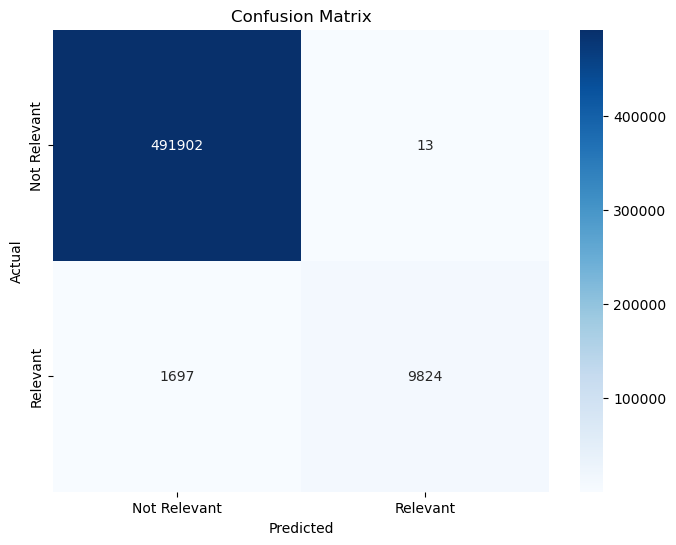

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plotting SVR results (for regression)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.3, label='SVR Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.title('SVR Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'y_pred' is not defined

<Figure size 1000x600 with 0 Axes>